In [2]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

plt.set_cmap('gray')


objpoints = []
imgpoints = []

for impath in glob.glob('camera_cal/*'):
    imdata_bgr = cv2.imread(impath)
    imdata_gray = cv2.cvtColor(imdata_bgr, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(imdata_gray, (9, 6))
    if not ret:
        print('Warning: Could not extract corners from chessboard'
              f'image {impath}')
        continue

    imgpoints.append(corners)

    objp = np.zeros((9 * 6, 3), np.float32)
    objp[:,:2] = np.mgrid[:9, :6].T.reshape(-1, 2)
    objpoints.append(objp)


# all images are the same size, so use the shape of the last one
imshape = imdata_gray.shape[::-1]
ret, camera_mtx, camera_dist, _, _ = cv2.calibrateCamera(
    objpoints, imgpoints, imshape, None, None)
    
if not ret:
    raise Exception('Could not calibrate camera!')

Text(0.5,1,'Undistorted')

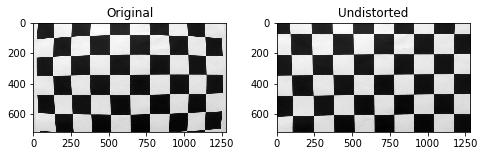

In [3]:
%matplotlib inline

imdata_bgr = cv2.imread('camera_cal/calibration1.jpg')
imdata_gray = cv2.cvtColor(imdata_bgr, cv2.COLOR_BGR2GRAY)
undistorted = cv2.undistort(
    imdata_gray, camera_mtx, camera_dist, None, camera_mtx)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))
ax1.imshow(imdata_gray)
ax1.set_title('Original')
ax2.imshow(undistorted)
ax2.set_title('Undistorted')

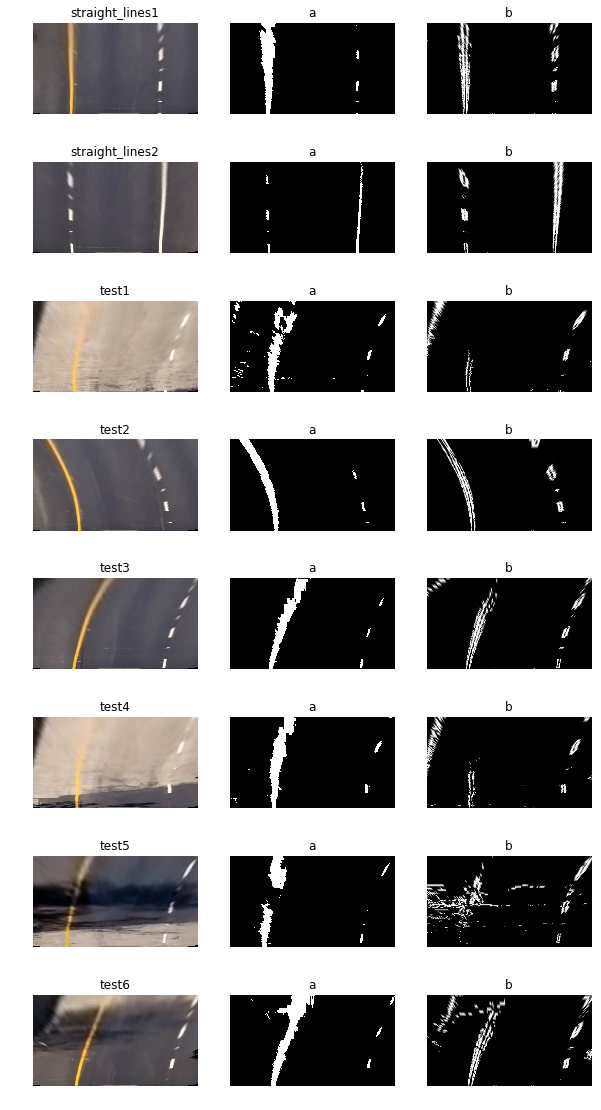

In [56]:
from cached_property import cached_property
import math

def getattr_multi(obj, attrs):
    rv = obj
    for attr in attrs.split('.'):
        rv = getattr(rv, attr)
    return rv


class ImageProcessor:
    SOBEL_MAX = 500

    def __init__(self, path):
        self.path = path
    
    @cached_property
    def base_img_name(self):
        return self.path.split('/')[-1].split('.')[0]
    
    @cached_property
    def orig(self):
        return cv2.cvtColor(cv2.imread(self.path), cv2.COLOR_BGR2RGB)
    
    @cached_property
    def gray(self):
        return cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2GRAY)

    @cached_property
    def undistorted(self):
        return cv2.undistort(self.orig, camera_mtx, camera_dist,
                             None, camera_mtx)

    def fixed_perspective_transform(self, img):
        # hardcoded input points gotten from looking at image in GIMP
        src = np.float32([
            [595, 450],  # top left
            [685, 450],  # top right
            [244, 686],  # bottom left
            [1063, 686],  # bottom right
        ])

        margin_x = 200
        margin_y = 0
        size = 500
        dst = np.float32([
            [margin_x, margin_y],  # top left
            [margin_x + size - 1, margin_y],  # top right
            [margin_x, margin_y + size - 1],  # bottom left
            [margin_x + size - 1, margin_y + size - 1],  # bottom right
        ])

        M = cv2.getPerspectiveTransform(src, dst)
        
        return cv2.warpPerspective(
            img,
            M,
            (size + margin_x * 2, size + margin_y * 2),
        )
    
    @cached_property
    def saturation(self):
        return cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2HLS)[:,:,2]

    def sobel(self, img, x, y):
        sobel = cv2.Sobel(
            img, cv2.CV_64F, x, y)
        abs_sobel = np.abs(sobel)
        scaled_sobel = 255 * np.clip(
            abs_sobel / self.SOBEL_MAX,
            0, 1)
        return np.uint8(scaled_sobel)
    
    def sobel_mag(self, sobel_x, sobel_y):
        return np.uint8(np.sqrt(
            np.power(sobel_x, 2, dtype=np.float32)
            + np.power(sobel_y, 2, dtype=np.float32)
        ) / math.sqrt(2))

    @cached_property
    def gray_sobel_x(self):
        return self.sobel(self.gray, 1, 0)
    
    @cached_property
    def gray_sobel_y(self):
        return self.sobel(self.gray, 0, 1)
    
    @cached_property
    def gray_sobel_mag(self):
        return self.sobel_mag(self.gray_sobel_x, self.gray_sobel_y)
        
    @cached_property
    def sat_sobel_x(self):
        return self.sobel(self.saturation, 1, 0)
        
    @cached_property
    def sat_sobel_y(self):
        return self.sobel(self.saturation, 0, 1)

    @cached_property
    def sat_sobel_mag(self):
        return self.sobel_mag(self.sat_sobel_x, self.sat_sobel_y)
    
    def sobel_angle(self, img):
        # angle of the gradient
        # taken modulo pi so that e.g. up and to the right is the
        # same as down and to the left
        # 0 represents 0 rad, 255 represents pi rad
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, 5)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, 5)
        ang = np.arctan2(sobel_y, sobel_x)
        ang = np.mod(ang, math.pi)
        return np.uint8(ang * 255 / math.pi)
    
    def sobel_angle_thresh(self, img):
        min_degrees = 30
        max_degrees = 60
        min_val = min_degrees * 255 / 180
        max_val = max_degrees * 255 / 180
        opp = 255 - img
        binary_mask = (
            (img > min_val)
             & (img < max_val)
            | (opp > min_val)
               & (opp < max_val)
        )
        return np.uint8(binary_mask) * 255
    
    @cached_property
    def gray_sobel_angle_thresh(self):
        return self.sobel_angle_thresh(self.gray)

    @cached_property
    def sat_sobel_angle_thresh(self):
        return self.sobel_angle_thresh(self.saturation)
    
    @cached_property
    def combined_sobel_thresh(self):
        gray_binary = (
            (self.gray_sobel_x > 63)
            & (self.gray_sobel_y > 63)
            | self.gray_sobel_angle_thresh
              & (self.gray_sobel_mag > 63)
        )
        sat_binary = (
            (self.sat_sobel_x > 63)
            & (self.sat_sobel_y > 63)
            | self.sat_sobel_angle_thresh
              & (self.sat_sobel_mag > 63)
        )
        binary = gray_binary | sat_binary
        return np.uint8(255 * binary)

    @cached_property
    def yellow(self):
        hsv = cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2HSV)
        h = hsv[:,:,0]
        s = hsv[:,:,1]
        binary = (15 <= h) & (h <= 30) & (s > 55)
        return np.uint8(binary * 255)
    
    @cached_property
    def white(self):
        hsv = cv2.cvtColor(self.undistorted, cv2.COLOR_RGB2HSV)
        s = hsv[:,:,1]
        v = hsv[:,:,2]
        binary = (s < 32) & (v >= 224) 
        return np.uint8(binary * 255)
    
    @cached_property
    def y_or_w(self):
        return np.uint8((self.yellow | self.white) * 255)
    
    @property
    def lane_lines(self):
        return self.y_or_w

    @property
    def p(self_outer):
        class PerspectiveTransformer:
            def __getattr__(self, name):
                return self_outer.fixed_perspective_transform(
                    getattr(self_outer, name))

        return PerspectiveTransformer()

    def save(self):
        for prop in ['undistorted', 'p.undistorted']:
            img = getattr_multi(self, prop)
            
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            prop = prop.replace('p.', 'perspective_')

            cv2.imwrite(
                f'output_images/{self.base_img_name}_{prop}.jpg',
                img)


all_images = sorted(glob.glob('test_images/*'))
_, axes = plt.subplots(len(all_images), 3, figsize=(10, 20))

for idx, path in enumerate(all_images):
    imp = ImageProcessor(path)
    imp.save()
    axes[idx][0].imshow(imp.p.undistorted)
    axes[idx][0].set_title(imp.base_img_name)
    axes[idx][0].axis('off')
    axes[idx][1].imshow(imp.p.lane_lines)
    axes[idx][1].set_title('a')
    axes[idx][1].axis('off')
    axes[idx][2].imshow(imp.p.combined_sobel_thresh)
    axes[idx][2].set_title('b')
    axes[idx][2].axis('off')


In [57]:
255 / 100 * 70

178.5